In [2]:
import pandas as pd
import numpy as np
from os.path import isfile
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import textwrap

In [2]:
result_path = "../../results/gene_enrichment_analysis/goatools/"
data_path = "../../results/rsem/"
samples_path = "../../data/rsem/samples.csv"
samples_dataframe = pd.read_csv(samples_path)

# Preparation of input files for goatools

In [3]:
dataframes = []
for unique_sample in samples_dataframe.treatment.unique():
    for unique_sample_2 in samples_dataframe.treatment.unique():
        if unique_sample != unique_sample_2:
            file = data_path + unique_sample + "_vs_" + unique_sample_2 + ".CSV"
            if isfile(file):
                dataframes.append(file)
dataframes

['../../results/rsem/liquid_mono_culture_orgint_vs_metatranscriptome.CSV',
 '../../results/rsem/liquid_mono_culture_orgint_vs_plate_mono_culture_kiel.CSV',
 '../../results/rsem/liquid_mono_culture_orgint_vs_liquid_mono_culture_kiel.CSV',
 '../../results/rsem/liquid_mono_culture_orgint_vs_hydra_mono_culture_kiel.CSV',
 '../../results/rsem/metatranscriptome_vs_liquid_mono_culture_orgint.CSV',
 '../../results/rsem/metatranscriptome_vs_plate_mono_culture_kiel.CSV',
 '../../results/rsem/metatranscriptome_vs_liquid_mono_culture_kiel.CSV',
 '../../results/rsem/metatranscriptome_vs_hydra_mono_culture_kiel.CSV',
 '../../results/rsem/plate_mono_culture_kiel_vs_liquid_mono_culture_orgint.CSV',
 '../../results/rsem/plate_mono_culture_kiel_vs_metatranscriptome.CSV',
 '../../results/rsem/plate_mono_culture_kiel_vs_liquid_mono_culture_kiel.CSV',
 '../../results/rsem/plate_mono_culture_kiel_vs_hydra_mono_culture_kiel.CSV',
 '../../results/rsem/liquid_mono_culture_kiel_vs_liquid_mono_culture_orgint.CSV

In [4]:
curvibacter_genes_df = pd.read_csv("../../results/curvibacter_genome_annotation.csv")
curvibacter_genes_df["gene_id"] = curvibacter_genes_df["gene_id"].apply(lambda x: "gene:"+x)
curvibacter_genes_df.head()

,Unnamed: 0,locus_tag,gene_id,wp_number,description,GO,GO_process
0,0,AEP_RS00005,gene:AEP_00001,WP_087493495.1,response regulator transcription factor,"GO:0000160,GO:0006355,GO:0003677",phosphorelay signal transduction system|000016...
1,1,AEP_RS00010,gene:AEP_00002,WP_087493496.1,sodium-translocating pyrophosphatase,"GO:1902600,GO:0009678",proton transmembrane transport|1902600||IEA
2,2,AEP_RS00015,gene:AEP_00003,WP_087493497.1,inorganic diphosphatase,"GO:0006796,GO:0004427",phosphate-containing compound metabolic proces...
3,3,AEP_RS00020,gene:AEP_00004,WP_087493498.1,alpha/beta fold hydrolase,unknown,unknown
4,4,AEP_RS00025,gene:AEP_00005,WP_087493499.1,chemotaxis protein CheW,"GO:0006935,GO:0007165","chemotaxis|0006935||IEA,signal transduction|00..."


In [5]:
# writing population and associations file 
go_gene_ids = []
with open(result_path + "associations.txt", "w") as associations_file:
    with open(result_path + "populations.txt", "w") as populations_file:
        for gene_id in curvibacter_genes_df["gene_id"]:
            if curvibacter_genes_df[curvibacter_genes_df["gene_id"] == gene_id].GO.values[0] != "unknown":
                
                go_gene_ids.append(gene_id)
                populations_file.write(gene_id+"\n")
                associations_file.write(gene_id + "\t")
                counter = 0
                gos = curvibacter_genes_df[curvibacter_genes_df["gene_id"] == gene_id].GO.values[0].split(",")
                for go_id in gos:
                    
                    if counter != len(gos)-1:
                        associations_file.write(go_id+";")
                    else:
                        associations_file.write(go_id+"\n")
                    counter += 1

In [6]:
# writing sample files for up/down regulated genes
go_files = []
for df in dataframes:
    print("[+] Working with: {}".format(df))
    log2folddf = pd.read_csv(df)
    log2folddf.columns = ["gene_id","baseMean","log2FoldChange","lfcSE","stat","pvalue","padj"]
    log2folddf = log2folddf[log2folddf["padj"] <= 0.05]
    downregulated_genes = log2folddf[log2folddf["log2FoldChange"] <= -1.0]
    upregulated_genes = log2folddf[log2folddf["log2FoldChange"] >= 1.0]

    downregulated_genes = downregulated_genes[downregulated_genes["gene_id"].isin(go_gene_ids)]
    upregulated_genes = upregulated_genes[upregulated_genes["gene_id"].isin(go_gene_ids)]
    
    
    print("\t[*] Length of downregulated genes: {}".format(len(downregulated_genes)))
    print("\t[*] Length of upregulated genes: {}".format(len(upregulated_genes)))
    
    sample = df.split("/")[-1].split(".CSV")[0] 
    sample_up = result_path + sample + "_upregulated_genes_goatools.txt"
    sample_down = result_path + sample + "_downregulated_genes_goatools.txt"
    
    if len(downregulated_genes) > 5:
        go_files.append(sample_down)
        with open(sample_down, "w") as goadown:
            for gene_id in downregulated_genes["gene_id"]:
                goadown.write(gene_id+"\n")
    if len(upregulated_genes) > 5:
        go_files.append(sample_up)
        with open(sample_up, "w") as goaup:
            for gene_id in upregulated_genes["gene_id"]:
                goaup.write(gene_id+"\n")

[+] Working with: ../../results/rsem/liquid_mono_culture_orgint_vs_metatranscriptome.CSV
	[*] Length of downregulated genes: 325
	[*] Length of upregulated genes: 344
[+] Working with: ../../results/rsem/liquid_mono_culture_orgint_vs_plate_mono_culture_kiel.CSV
	[*] Length of downregulated genes: 344
	[*] Length of upregulated genes: 331
[+] Working with: ../../results/rsem/liquid_mono_culture_orgint_vs_liquid_mono_culture_kiel.CSV
	[*] Length of downregulated genes: 221
	[*] Length of upregulated genes: 270
[+] Working with: ../../results/rsem/liquid_mono_culture_orgint_vs_hydra_mono_culture_kiel.CSV
	[*] Length of downregulated genes: 340
	[*] Length of upregulated genes: 531
[+] Working with: ../../results/rsem/metatranscriptome_vs_liquid_mono_culture_orgint.CSV
	[*] Length of downregulated genes: 344
	[*] Length of upregulated genes: 325
[+] Working with: ../../results/rsem/metatranscriptome_vs_plate_mono_culture_kiel.CSV
	[*] Length of downregulated genes: 501
	[*] Length of upreg

In [ ]:
goafiles = []
for samplefile in go_files:
    print("[+] Working with {}".format(samplefile))
    outfile = result_path + samplefile.split("/")[-1].split(".txt")[0] + "_output.table"
    
    !find_enrichment.py $samplefile ../../results/gene_enrichment_analysis/goatools/populations.txt ../../results/gene_enrichment_analysis/goatools/associations.txt --annofmt id2gos --alpha 0.05 --pval 0.05 --obo ../../results/gene_enrichment_analysis/goatools/go-basic.obo --method fdr_bh --outfile $outfile --obsolete replace > /dev/null
    
    goafiles.append(outfile)
    print("[*] DONE")

In [20]:
def plot_goa(goafile_enriched:pd.DataFrame,savep:str, filename:str):
    print("[*] Producing plot for {}".format(filename))
    goafile_enriched["ratio_stud"] = goafile_enriched.ratio_in_study.apply(lambda x: int(x.split("/")[0])/int(x.split("/")[1]))
    goafile_enriched["ratio_pop"] = goafile_enriched.ratio_in_pop.apply(lambda x: int(x.split("/")[0])/int(x.split("/")[1]))
    goafile_enriched["amount_in_pop"] = goafile_enriched.ratio_in_pop.apply(lambda x: int(x.split("/")[0]))
    
    categorical_indices = []
    categories = []
    for index, cat in enumerate(list(goafile_enriched.name)):
        if len(cat) >= 30:
            cat = textwrap.fill(cat, width=30)
            categorical_indices.append(index)
        categories.append(cat)
        
    values = list(goafile_enriched.study_count)
    scatter_values = np.array(goafile_enriched.study_count) / np.array(goafile_enriched.amount_in_pop)
    
    pcolors = goafile_enriched.p_fdr_bh
    norm_p_values = np.array(pcolors) / max(pcolors)
    colors=plt.cm.RdBu_r(norm_p_values)
    
    
    # Create figure and axes
    if len(goafile_enriched) == 30:
        fsize = (20,18)
    elif len(goafile_enriched) >= 15:
        fsize = (16,12)
    else:
        fsize = (12,8)
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 16), sharey=True)

    # Plot horizontal bar plot on ax1
    ax1.barh(categories, values, color=colors, edgecolor="black")

    ax1.set_xlabel('Count', fontsize=15, labelpad=20)
    ax1.tick_params(axis='y', labelsize=15) 
    ax1.tick_params(axis='x', labelsize=15) 
    
    
    # Accessing tick labels
    tick_labels = ax1.get_yticklabels()

    # Specify indices of labels to make bold (e.g., 1 and 3 in this example)

    # Update tick labels with LaTeX formatting for bold
    for i, label in enumerate(tick_labels):
        if i in categorical_indices:
            #label.set_fontweight('bold')
            label.set_fontsize(10)  # Optional: Adjust font size if needed
            #label.set_color('blue')  # Optional: Adjust font color if needed
            # Use LaTeX for bold formatting
            #label.set_text(r'\textbf{' + label.get_text() + r'}')
    
    
    ax2.scatter(scatter_values, categories, c=colors, cmap='RdBu_r', 
                label='Gene Ratio (compared to Study)', s=list(goafile_enriched.ratio_stud*1000),edgecolor="black")

    ax2.set_xlabel('Count in Study / Count in Pop', fontsize=15, labelpad=20)
    
    ax2.tick_params(axis='x', labelsize=15) 
    #ax1.set_ylabel('GO Categories')
    ax1.invert_yaxis()
    plt.subplots_adjust(left=0.2, wspace=0.1)
    cbar = fig.colorbar(ScalarMappable(cmap='RdBu_r'), ax=[ax1, ax2], pad = 0.005)
    cbar.set_label('p-values',fontsize=15, labelpad=20)
    cbar.set_ticks([min(norm_p_values), max(norm_p_values)])
    cbar.set_ticklabels([f'{min(goafile_enriched.p_fdr_bh):.4f}', f'{max(goafile_enriched.p_fdr_bh):.4f}'])
    cbar.ax.tick_params(labelsize=12)

    cbar.ax.set_position([0.85, 0.15, 0.03, 0.7])
    
    #plt.show()
    plt.savefig(savep + filename + ".jpg", dpi=400)
    plt.close()
    print("[*] DONE")

In [ ]:
for goafile in goafiles:
    if isfile(goafile):
        goafigure = goafile.split("/")[-1].split("_goatools_output.table")[0]
        dataframe = pd.read_table(goafile)
        plot_goa(dataframe, result_path, goafigure)

# Goatools on symbiotic protein ids

In [3]:
translation_table = pd.read_table("../../data/curvibacter_annotation_files/translation_table_corrected.csv")
translation_table.head()

,protein_id,old_locus_tag,locus_tag
0,WP_087493495.1,AEP_00001,AEP_RS00005
1,WP_087493496.1,AEP_00002,AEP_RS00010
2,WP_087493497.1,AEP_00003,AEP_RS00015
3,WP_087493498.1,AEP_00004,AEP_RS00020
4,WP_087493499.1,AEP_00005,AEP_RS00025


In [154]:
log2Fold_df = pd.read_csv('../../results/rsem/liquid_mono_culture_orgint_vs_metatranscriptome.CSV')
#log2Fold_df = pd.read_csv('../../results/rsem/liquid_mono_culture_kiel_vs_hydra_mono_culture_kiel.csv')
log2Fold_df.columns = ["old_locus_tag","baseMean","log2FoldChange","lfcSE","stat","pvalue","padj"]
log2Fold_df.head()

,old_locus_tag,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,gene:AEP_03681,347.201998,3.984929,0.259730,15.342584,3.970701e-53,1.625605e-49
1,gene:AEP_03686,543.977584,5.451815,0.364200,14.969285,1.165671e-50,2.386129e-47
2,gene:AEP_02246,299.904354,2.985833,0.212857,14.027385,1.059888e-44,1.446394e-41
3,gene:AEP_02386,218.435490,-2.735419,0.197180,-13.872702,9.271727e-44,9.489612e-41
4,gene:AEP_03682,399.600103,4.500241,0.326495,13.783490,3.203994e-43,2.623431e-40


In [155]:
log2Fold_df = log2Fold_df[log2Fold_df["padj"] <= 0.05]
print(len(log2Fold_df))

1911


In [156]:
symbiotic_protein_ids = pd.read_csv("../../data/symbiotic_wps/caep_symbiotic_wps.txt", header=None)
symbiotic_protein_ids.columns = ["protein_id"]
merged_table = translation_table.merge(symbiotic_protein_ids, on="protein_id")
merged_table["old_locus_tag"] = merged_table["old_locus_tag"].apply(lambda x: "gene:"+x)

In [157]:
pop_ids = []
with open("../../results/gene_enrichment_analysis/goatools/populations.txt","r") as populationfile:
    for line in populationfile:
        pop_ids.append(line.strip())

In [158]:
with open("../../data/symbiotic_wps/go_gene_id_goatools.txt", "w") as goatools:
    for gene in merged_table[merged_table["old_locus_tag"].isin(pop_ids) == True]["old_locus_tag"]:
        goatools.write(gene.strip()+"\n")

In [159]:
!find_enrichment.py ../../data/symbiotic_wps/go_gene_id_goatools.txt ../../results/gene_enrichment_analysis/goatools/populations.txt ../../results/gene_enrichment_analysis/goatools/associations.txt --annofmt id2gos --alpha 0.05 --pval 0.05 --obo ../../results/gene_enrichment_analysis/goatools/go-basic.obo --method fdr_bh --outfile ../../results/gene_enrichment_analysis/symbiotic_genes/symbiotic_proteins_enrichment.txt --obsolete replace > /dev/null

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [160]:
dataframe = pd.read_table("../../results/gene_enrichment_analysis/symbiotic_genes/symbiotic_proteins_enrichment.txt")
plot_goa(dataframe, "../../results/gene_enrichment_analysis/symbiotic_genes/", "symbiotic_proteins")

[*] Producing plot for symbiotic_proteins
[*] DONE


# Up/Down regulated symbiotic proteins

In [161]:
log2FoldChange_table = merged_table.merge(log2Fold_df, on="old_locus_tag")
upregulated = log2FoldChange_table[log2FoldChange_table.log2FoldChange <= -1.0]
downregulated = log2FoldChange_table[log2FoldChange_table.log2FoldChange >= 1.0]
unregulated = log2FoldChange_table[abs(log2FoldChange_table.log2FoldChange)<1.0]

In [162]:
with open("../../data/symbiotic_wps/go_gene_id_upregulated_on_host_goatools.txt", "w") as goatools:
    for gene in upregulated[upregulated["old_locus_tag"].isin(pop_ids) == True]["old_locus_tag"]:
        goatools.write(gene.strip()+"\n")

In [163]:
!find_enrichment.py ../../data/symbiotic_wps/go_gene_id_upregulated_on_host_goatools.txt ../../results/gene_enrichment_analysis/goatools/populations.txt ../../results/gene_enrichment_analysis/goatools/associations.txt --annofmt id2gos --alpha 0.05 --pval 0.05 --obo ../../results/gene_enrichment_analysis/goatools/go-basic.obo --method fdr_bh --outfile ../../results/gene_enrichment_analysis/symbiotic_genes/symbiotic_proteins_upregulated_on_host_enrichment.txt --obsolete replace > /dev/null

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [164]:
dataframe = pd.read_table("../../results/gene_enrichment_analysis/symbiotic_genes/symbiotic_proteins_upregulated_on_host_enrichment.txt")
plot_goa(dataframe, "../../results/gene_enrichment_analysis/symbiotic_genes/", "symbiotic_upregulated_proteins")

[*] Producing plot for symbiotic_upregulated_proteins
[*] DONE


In [165]:
significant_proteins = []
for item in dataframe.study_items:
    for protein in item.split(","):
        
        protein = protein.strip()
        
        if protein not in significant_proteins:
            significant_proteins.append(protein)
enriched_upregulated = log2FoldChange_table[log2FoldChange_table["old_locus_tag"].isin(significant_proteins)]

In [166]:
annotations = pd.read_csv("../../results/curvibacter_genome_annotation.csv", index_col=0)
annotations.rename(columns={"wp_number":"protein_id"}, inplace=True)
annotations.head()

,locus_tag,gene_id,protein_id,description,GO,GO_process
0,AEP_RS00005,AEP_00001,WP_087493495.1,response regulator transcription factor,"GO:0000160,GO:0006355,GO:0003677",phosphorelay signal transduction system|000016...
1,AEP_RS00010,AEP_00002,WP_087493496.1,sodium-translocating pyrophosphatase,"GO:1902600,GO:0009678",proton transmembrane transport|1902600||IEA
2,AEP_RS00015,AEP_00003,WP_087493497.1,inorganic diphosphatase,"GO:0006796,GO:0004427",phosphate-containing compound metabolic proces...
3,AEP_RS00020,AEP_00004,WP_087493498.1,alpha/beta fold hydrolase,unknown,unknown
4,AEP_RS00025,AEP_00005,WP_087493499.1,chemotaxis protein CheW,"GO:0006935,GO:0007165","chemotaxis|0006935||IEA,signal transduction|00..."


In [167]:
annotations.merge(enriched_upregulated, on="protein_id")[["protein_id","description", "log2FoldChange", "GO","GO_process"]].sort_values(by="log2FoldChange")

,protein_id,description,log2FoldChange,GO,GO_process
15,WP_087496052.1,ABC transporter permease subunit,-2.309343,"GO:0015837,GO:0005886,GO:0055052",amine transport|0015837||IEA
14,WP_087496051.1,ABC transporter permease subunit,-1.947061,"GO:0015837,GO:0005886,GO:0055052",amine transport|0015837||IEA
19,WP_087497061.1,MIP/aquaporin family protein,-1.720409,"GO:0055085,GO:0015267",transmembrane transport|0055085||IEA
3,WP_198301900.1,cation transporter,-1.676250,"GO:0006812,GO:0055085,GO:0008324,GO:0016020","monoatomic cation transport|0006812||IEA,trans..."
12,WP_087495952.1,ABC transporter permease,-1.629143,"GO:0008643,GO:0022857,GO:0005886",carbohydrate transport|0008643||IEA
8,WP_087495749.1,carbohydrate ABC transporter permease,-1.625337,"GO:0008643,GO:0055085","carbohydrate transport|0008643||IEA,transmembr..."
13,WP_087495954.1,L-rhamnose mutarotase,-1.584346,"GO:0019301,GO:0062192",rhamnose catabolic process|0019301||IEA
11,WP_198301829.1,SIS domain-containing protein,-1.491558,"GO:0005975,GO:0016787,GO:0097367",carbohydrate metabolic process|0005975||IEA
16,WP_232459837.1,homocysteine S-methyltransferase,-1.484536,"GO:0009086,GO:0047150",methionine biosynthetic process|0009086||IEA
4,WP_087497223.1,metal ABC transporter permease,-1.409474,"GO:0030001,GO:0055085,GO:0043190","metal ion transport|0030001||IEA,transmembrane..."


In [168]:
counts = []
pvals = []
counts_pop = []
labels = []
ratio = []

for count, pval, count_pop, label, go in zip(dataframe["study_count"],
                                             dataframe["p_fdr_bh"],
                                             dataframe["amount_in_pop"],
                                             dataframe["name"],
                                             dataframe["# GO"]):
    
    labels.append(go + " " + label)
    counts.append(count)
    pvals.append(pval)
    counts_pop.append(count_pop)
    ratio.append(count/count_pop)
    #print(count, pval, count_pop,label, go)

marker_size = ratio
pcolors = pvals
norm_p_values = np.array(pcolors) / max(pcolors)
colors=plt.cm.RdBu_r(norm_p_values)
marker_legend = marker_size
marker_legend = sorted(marker_legend, reverse=True)
sorted_markersize = sorted(np.array(marker_legend)*10000, reverse=True)
sorted_markers = sorted(marker_legend, reverse=True)

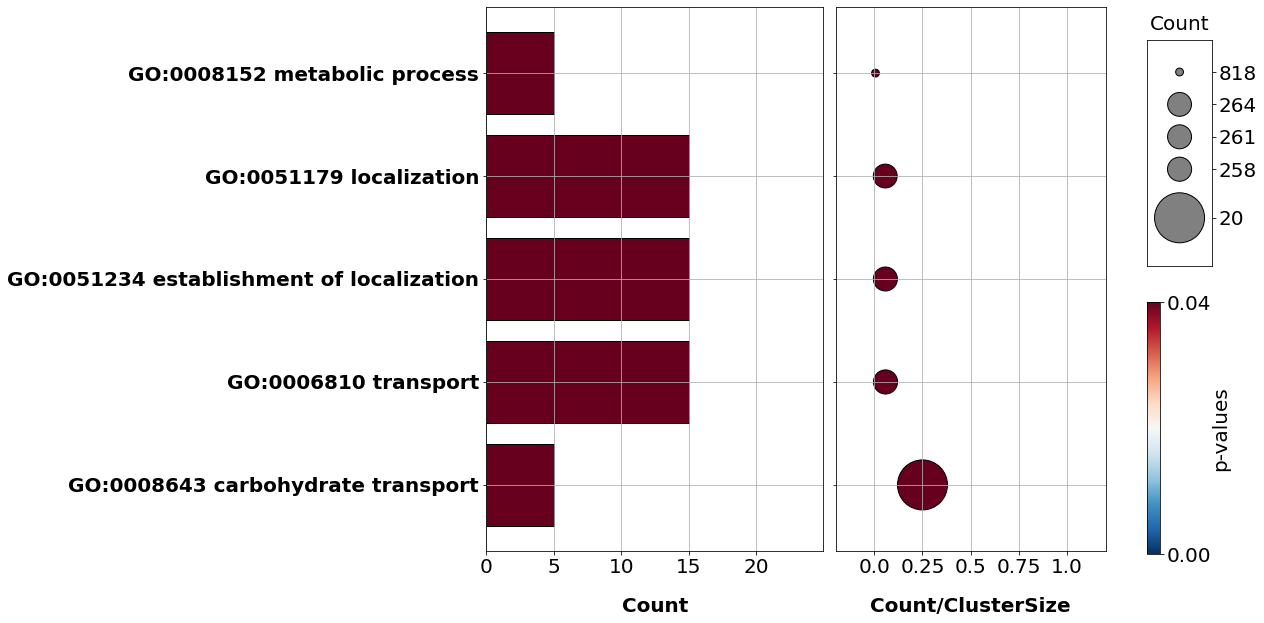

In [177]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 10), sharey=False, gridspec_kw={'width_ratios': [2.5, 2.0, 1]})

ax1.sharey(ax2)

ax1.barh(labels,width=counts, color=colors, edgecolor="black")
ax2.scatter(y=[0,1,2,3,4], x=ratio, s=np.array(marker_size)*10000, c=colors, cmap='RdBu_r', edgecolors="black")

ax1.set_xlim(0,25)
#ax1.set_xticklabels(fontsize=16)
ax1.set_xticks([0,5,10,15,20])
ax1.set_xticklabels([0,5,10,15,20], fontsize=20)
ax1.set_yticks([0,1,2,3,4])
ax1.set_yticklabels(labels, fontsize=20, fontdict={'fontweight':"bold"})
ax1.set_xlabel("Count", fontsize=20, labelpad=20,  fontdict={'fontweight':"bold"})
ax1.grid()

ax2.set_xlim(-0.2,1.2)
ax2.set_xticks([0.0,0.25,0.5,0.75,1.0])
ax2.set_xticklabels([0.0,0.25,0.5,0.75,1.0], fontsize=20)
ax2.set_xlabel("Count/ClusterSize", fontsize=20, labelpad=20,  fontdict={'fontweight':"bold"})
ax2.tick_params(axis='y', labelleft=False)
ax2.grid()

plt.subplots_adjust(left=0.2, wspace=0.05)

cbar = fig.colorbar(ScalarMappable(cmap='RdBu_r'), ax=[ax1, ax2], pad = 0.005)
cbar.set_label('p-values',fontsize=20, labelpad=0)
cbar.set_ticks([0, 1])
cbar.set_ticklabels([f'{0:.2f}', f'{max(pvals):.2f}'])
cbar.ax.tick_params(labelsize=20)

cbar.ax.set_position([0.71, 0.12, 0.03, 0.35])

ax3.set_position([0.71, 0.52, 0.05, 0.315])
ax3.scatter(x=[0.5 for i in labels], y=[0.5,2,3,4,5], s=sorted_markersize, color="grey", edgecolor="black")
ax3.set_yticks([0.5,2,3,4,5])
ax3.set_yticklabels(counts_pop, fontsize=20)
ax3.set_xlim(0,1)
ax3.set_ylim(-1,6)
ax3.tick_params(axis='y', labelright=True, labelleft=False)
ax3.tick_params(axis='x', labelbottom=False)
ax3.set_xticks([])
ax3.yaxis.tick_right()   
ax3.set_title("Count", pad=10, fontsize=20)
#ax3.grid()
#ax3.axis("off")
plt.savefig("../../results/gene_enrichment_analysis/up_symbiotic_combined.jpg", dpi=400, bbox_inches='tight')
#plt.tight_layout()

In [151]:
with open("../../data/symbiotic_wps/go_gene_id_downregulated_on_host_goatools.txt", "w") as goatools:
    for gene in downregulated[downregulated["old_locus_tag"].isin(pop_ids) == True]["old_locus_tag"]:
        goatools.write(gene.strip()+"\n")

In [152]:
!find_enrichment.py ../../data/symbiotic_wps/go_gene_id_downregulated_on_host_goatools.txt ../../results/gene_enrichment_analysis/goatools/populations.txt ../../results/gene_enrichment_analysis/goatools/associations.txt --annofmt id2gos --alpha 0.05 --pval 0.05 --obo ../../results/gene_enrichment_analysis/goatools/go-basic.obo --method fdr_bh --outfile ../../results/gene_enrichment_analysis/symbiotic_genes/symbiotic_proteins_downregulated_on_host_enrichment.txt --obsolete replace

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
../../results/gene_enrichment_analysis/goatools/go-basic.obo: fmt(1.2) rel(2024-06-10) 51,502 Terms; optional_attrs(consider replaced_by)
[09/27/24 09:45:02] WARNING  GO:0045250 obsolete in DAG,    ]8;id=640723;file:///blast/miniconda3/lib/python3.8/site-packages/goatools/anno/init/reader_idtogos.py\reader_idtogos.py]8;;\:]8;id=580434;file:///blast/miniconda3/lib/python3.8/site-packages/goatools/anno/init/reader_idtogos.py#83\83]8;;\
                             replaced by {'GO:0045254'}                         
                    WARNING  GO:0055072 obsolete in DAG,    ]8;id=335679;file:///blast/miniconda3/lib/python3.8/site-packages/goatools/anno/init/reader_idtogos.py\reader_idtogos.py]8;;\:]8;id=456599;file:///blast/miniconda3/lib/python3.8/site-packages/goatools/anno/init/reader_i

Propagating term counts up: is_a
 63%  1,373 of  2,172 population items found in association

Load CC Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 23%    494 of  2,172 population items found in association

Load MF Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 88%  1,908 of  2,172 population items found in association

Runing BP Ontology Analysis: current study set of 39 IDs.
 59%     23 of     39 study items found in association
100%     39 of     39 study items found in population(2172)
Calculating 1,143 uncorrected p-values using fisher_scipy_stats
   1,143 terms are associated with  1,373 of  2,172 population items
      66 terms are associated with     23 of     39 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing CC Ont

In [27]:
#dataframe = pd.read_table("../../results/gene_enrichment_analysis/symbiotic_genes/symbiotic_proteins_downregulated_on_host_enrichment.txt")
#plot_goa(dataframe, "../../results/gene_enrichment_analysis/symbiotic_genes/", "symbiotic_downregulated_proteins")

In [120]:
with open("../../data/symbiotic_wps/go_gene_id_unregulated_on_host_goatools.txt", "w") as goatools:
    for gene in unregulated[unregulated["old_locus_tag"].isin(pop_ids) == True]["old_locus_tag"]:
        goatools.write(gene.strip()+"\n")

In [121]:
!find_enrichment.py ../../data/symbiotic_wps/go_gene_id_unregulated_on_host_goatools.txt ../../results/gene_enrichment_analysis/goatools/populations.txt ../../results/gene_enrichment_analysis/goatools/associations.txt --annofmt id2gos --alpha 0.05 --pval 0.05 --obo ../../results/gene_enrichment_analysis/goatools/go-basic.obo --method fdr_bh --outfile ../../results/gene_enrichment_analysis/symbiotic_genes/symbiotic_proteins_unregulated_on_host_enrichment.txt --obsolete replace

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
../../results/gene_enrichment_analysis/goatools/go-basic.obo: fmt(1.2) rel(2024-06-10) 51,502 Terms; optional_attrs(consider replaced_by)
[09/27/24 09:34:00] WARNING  GO:0045250 obsolete in DAG,    ]8;id=260244;file:///blast/miniconda3/lib/python3.8/site-packages/goatools/anno/init/reader_idtogos.py\reader_idtogos.py]8;;\:]8;id=578991;file:///blast/miniconda3/lib/python3.8/site-packages/goatools/anno/init/reader_idtogos.py#83\83]8;;\
                             replaced by {'GO:0045254'}                         
                    WARNING  GO:0055072 obsolete in DAG,    ]8;id=591159;file:///blast/miniconda3/lib/python3.8/site-packages/goatools/anno/init/reader_idtogos.py\reader_idtogos.py]8;;\:]8;id=557399;file:///blast/miniconda3/lib/python3.8/site-packages/goatools/anno/init/reader_i

Propagating term counts up: is_a
 23%    494 of  2,172 population items found in association

Load MF Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 88%  1,908 of  2,172 population items found in association

Runing BP Ontology Analysis: current study set of 21 IDs.
 57%     12 of     21 study items found in association
100%     21 of     21 study items found in population(2172)
Calculating 1,143 uncorrected p-values using fisher_scipy_stats
   1,143 terms are associated with  1,373 of  2,172 population items
      70 terms are associated with     12 of     21 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 21 IDs.
 33%      7 of     21 study items found in association
100%     21 of     21 study items f

In [178]:
#dataframe = pd.read_table("../../results/gene_enrichment_analysis/symbiotic_genes/symbiotic_proteins_unregulated_on_host_enrichment.txt")
#plot_goa(dataframe, "../../results/gene_enrichment_analysis/symbiotic_genes/", "symbiotic_downregulated_proteins")

In [180]:
merged_table.to_csv("../../results/gene_enrichment_analysis/symbiotic_genes/merged_translation_table.csv")